In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.sandbox.stats.multicomp import multipletests
from collections import Counter
from tqdm import tqdm_notebook

%matplotlib inline

## Критерии согласия

### Критерий согласия Пирсона (хи-квадрат)

$H_0:$ Выборка из некоторого класса распределений

$H_1: H_0$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#scipy.stats.chisquare">`chisquare`</a>`(f_obs, f_exp=None, ddof=0)`

* `f_obs` --- число элементов выборки, попавших в каждый из интервалов
* `f_exp` --- ожидаемое число (по умолчанию равномерное)
* `ddof` --- поправка на число степеней свободы. Статистика асимптотически будет иметь распределение $k - 1 - ddof$, где $k$ --- число интервалов.

In [2]:
sps.chisquare([16, 18, 16, 14, 12, 12])

Power_divergenceResult(statistic=2.0, pvalue=0.8491450360846096)

In [3]:
sps.chisquare([16, 18, 16, 14, 12, 12], f_exp=[16, 16, 16, 16, 20, 4])

Power_divergenceResult(statistic=19.7, pvalue=0.0014224993317060594)

In [6]:
sps.chisquare([16, 18, 16, 14, 12, 12], f_exp=[16, 16, 16, 16, 24, 0])

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4554: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


Power_divergenceResult(statistic=inf, pvalue=0.0)

Эксперимент с группами крови

In [5]:
sps.chisquare([121, 120, 79, 33], f_exp=np.array([0.343, 0.340, 0.224, 0.093]) * 353, ddof=2)

Power_divergenceResult(statistic=0.001011144526478114, pvalue=0.9746327438096731)

Посмотрим, насколько хорошо выполняется асимптотика при справедливости нулевой гипотезы для разных распределений.

**1.** Равномерное на 5 элементах

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

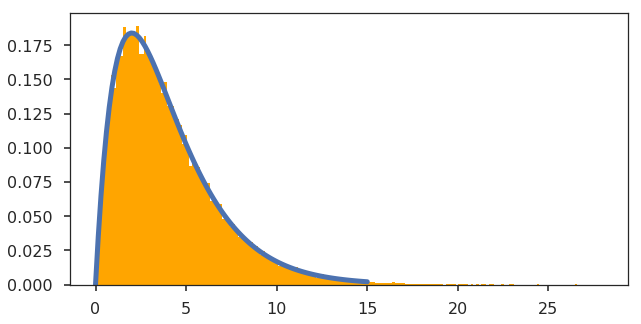

In [7]:
sample_size = 1000
sample_count = 100000
chisq_values = np.zeros(sample_count)

for i in tqdm_notebook(range(sample_count)):
    sample = sps.randint(low=0, high=5).rvs(size=sample_size)
    f_obs = np.array(list(Counter(sample).values()))
    chisq_values[i] = sps.chisquare(f_obs)[0]

sns.set(style='ticks', context='poster')
plt.figure(figsize=(10, 5))
grid = np.linspace(0, 15, 100)
plt.plot(grid, sps.chi2(df=4).pdf(grid), lw=5)
plt.hist(chisq_values, bins=200, color='orange', normed=True);

**2.** Равномерное на 4 элементах, а 5-й с очень маленькой вероятностью.

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

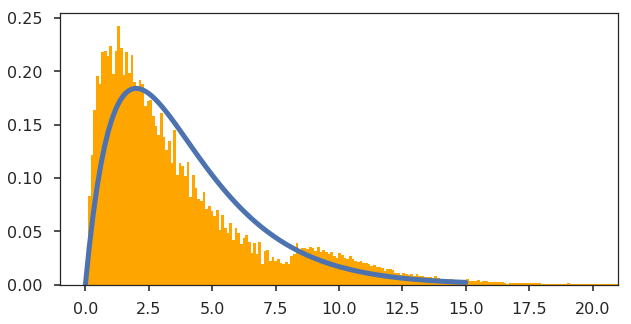

In [8]:
chisq_values = np.zeros(sample_count)

epsilon = 0.0001
pk = np.array([0.25 - epsilon / 4] * 4 + [epsilon])
some_distribution = sps.rv_discrete(name='1', values=(np.arange(5), pk))

for i in tqdm_notebook(range(sample_count)):
    sample = some_distribution.rvs(size=sample_size)
    f_obs = np.array(list(Counter(sample).values()))
    if len(f_obs) == 4: f_obs = np.append(f_obs,[0])
    f_exp = pk * sample_size
    chisq_values[i] = sps.chisquare(f_obs, f_exp=f_exp)[0]

sns.set(style='ticks', context='poster')
plt.figure(figsize=(10, 5))
grid = np.linspace(0, 15, 100)
plt.plot(grid, sps.chi2(df=4).pdf(grid), lw=5)
plt.hist(chisq_values, bins=200, color='orange', normed=True, range=(0, 21))
plt.xlim((-1, 21));

**Вывод:** асимптотика ломается, если есть интервалы с малой вероятностью или с малым числом элементов в выборке.

### Критерий согласия Колмогорова (-Смирнова) {для нормальных Лиллиефорса}

$H_0:$ Выборка из некоторого класса распределений

$H_1: H_0$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest">`kstest`</a>`(rvs, cdf, args=())`

* `rvs` --- выборка
* `cdf` --- функция распределения (сама функция или ее название)
* `args` --- параметры распределения

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

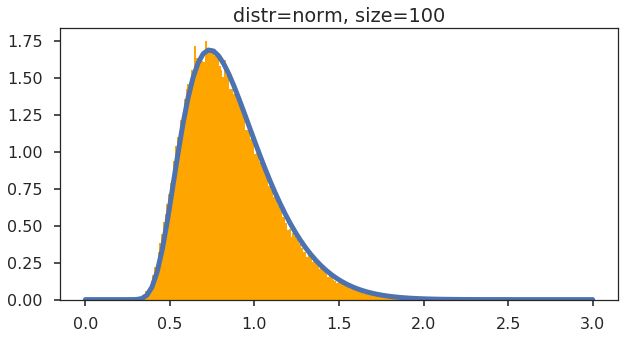

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

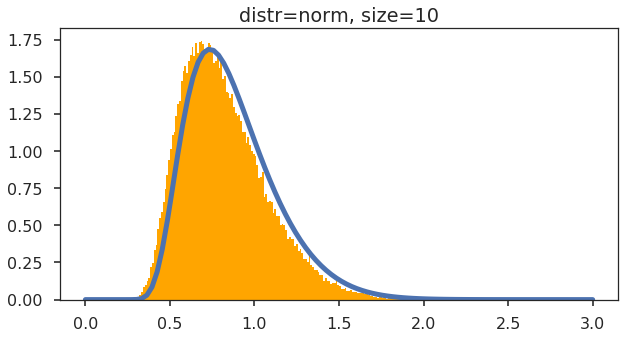

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

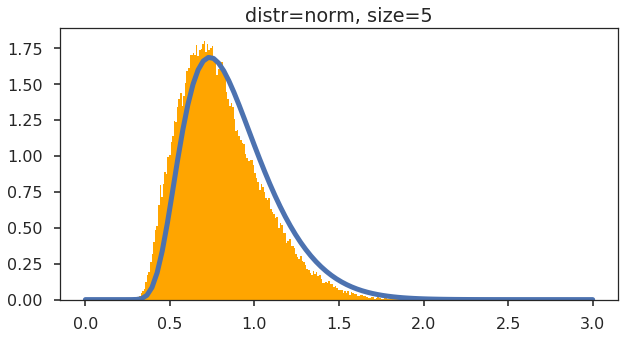

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

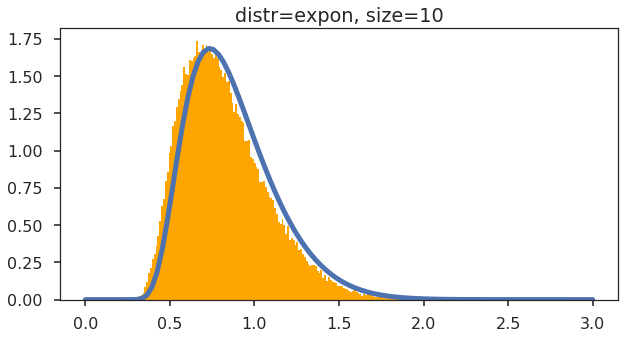

In [9]:
grid = np.linspace(0, 3, 100)
n_iter = 100000
sns.set(style='ticks', context='poster')

for size, distr in zip([100, 10, 5, 10], [sps.norm] * 3 + [sps.expon]):
    D = []
    
    samples = distr.rvs(size=(n_iter, size))
    for i in tqdm_notebook(range(n_iter), leave=False):
        D.append(sps.kstest(samples[i], cdf=distr.cdf)[0])

    plt.figure(figsize=(10, 5))
    plt.plot(grid, sps.kstwobign.pdf(grid), lw=5, label='Kolmogorov pdf')
    plt.hist(np.array(D) * np.sqrt(size), bins=200, normed=True, 
             label='hist $\\sqrt{n} D_n$', color='orange')
    plt.title('distr={}, size={}'.format(distr.name, size))
    plt.show()

Рассмотрим случай $H_0: \mathcal{N}(0, 1)$ 

In [10]:
sns.set(style='darkgrid', context='poster')

def apply_kstest(sample, cdf=sps.norm.cdf):
    print(sps.kstest(sample, sps.norm.cdf))

    ecdf = ECDF(sample)
    grid = np.linspace(-3, 3, 500)

    plt.figure(figsize=(8, 3.5))
    plt.plot(grid, ecdf(grid), color='red', label='ecdf', lw=2)
    plt.plot(grid, cdf(grid), color='blue', label='cdf', lw=2)
    plt.legend()
    plt.show()

Нулевая гипотеза верна:

KstestResult(statistic=0.07693159722619947, pvalue=0.582287675185106)


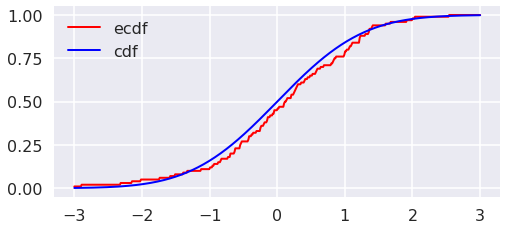

In [11]:
apply_kstest(sps.norm.rvs(size=100))

Истинное распределение - Лапласс

KstestResult(statistic=0.09081572915079733, pvalue=0.36191897744795254)


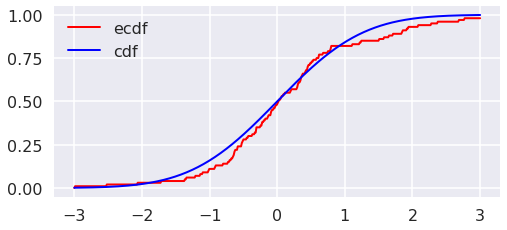

In [12]:
apply_kstest(sps.laplace.rvs(size=100))

Истинное распределение - Коши

KstestResult(statistic=0.1029394178997744, pvalue=0.22420082396039875)


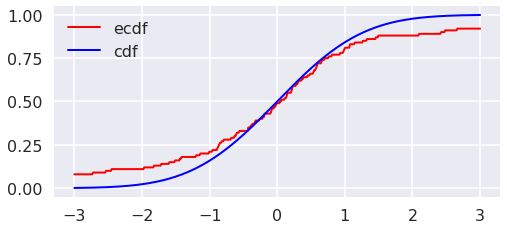

In [13]:
apply_kstest(sps.cauchy.rvs(size=100))

KstestResult(statistic=0.09265126671871954, pvalue=0.3378944664109582)


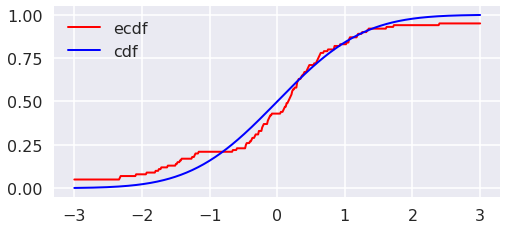

In [14]:
apply_kstest(sps.cauchy(scale=0.5).rvs(size=100))

KstestResult(statistic=0.07014399360124302, pvalue=0.7142282219314748)


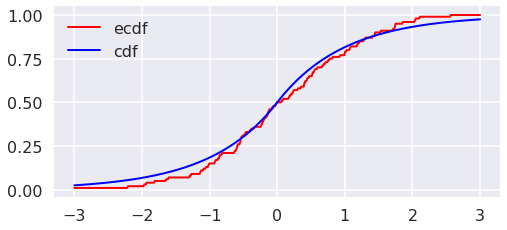

In [15]:
apply_kstest(sps.norm.rvs(size=100), cdf=sps.laplace.cdf)

**Вывод:** Критерий не чувствителен к хвостам распределений.

### Критерий Андерсона-Дарлинга

$H_0:$ Выборка из некоторого класса распределений

$H_1: H_0$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson">`anderson`</a>`(x, dist='norm')`

* `x` --- выборка
* `dist : {'norm', 'expon', 'logistic', 'gumbel'}` --- распределение

Возвращает `(statistic, critical_values, significance_level)`. В `critical_values` записаны пороги для критериев, которым соответствуют уровни значимости из `significance_level` в процентах. То есть критерий `{statistic > critical_values[i]}` имеет уровень значимости `significance_level[i]`.

In [16]:
sample = sps.norm.rvs(size=100)
sps.anderson(sample)

AndersonResult(statistic=0.367854993606187, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [17]:
sample = sps.laplace.rvs(size=100)
sps.anderson(sample)

AndersonResult(statistic=0.7377045143151122, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [18]:
sample = sps.cauchy.rvs(size=100)
sps.anderson(sample)

AndersonResult(statistic=22.39678741034247, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

### Q-Q plot

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html#scipy.stats.probplot">`probplot`</a>`(x, sparams=(), dist='norm', fit=True, plot=None)`

* `x` --- выборка
* `sparams` --- параметры распределения
* `dist` --- распределение
* `fit` --- подгонять ли линейную регрессию под точки
* `plot` --- рисовать на уже существующей фигуре

Возвращает:

* `(osm, osr)` --- теоретические и выборочные квантили
* `(slope, intercept, r)` --- не возвращается в случае `fit=False` и `plot=None`. Значения: коэффициенты линейной регрессии и RSS

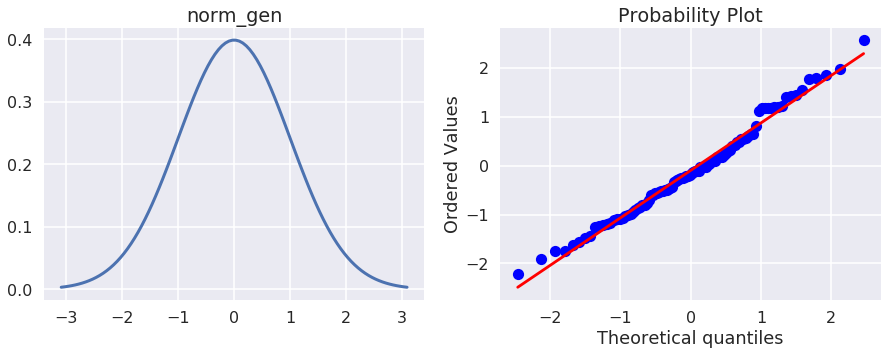

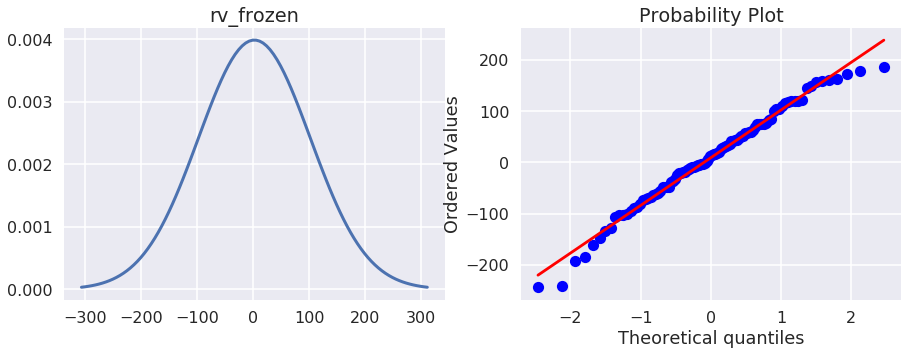

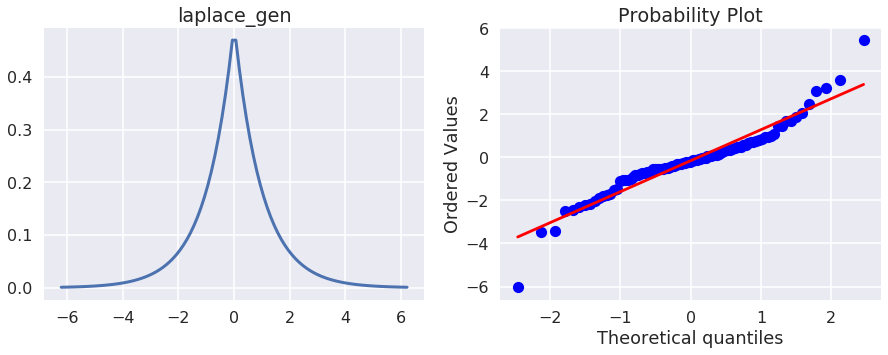

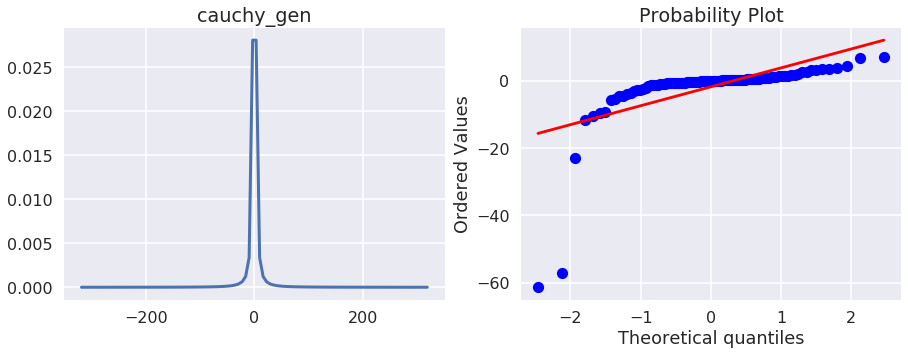

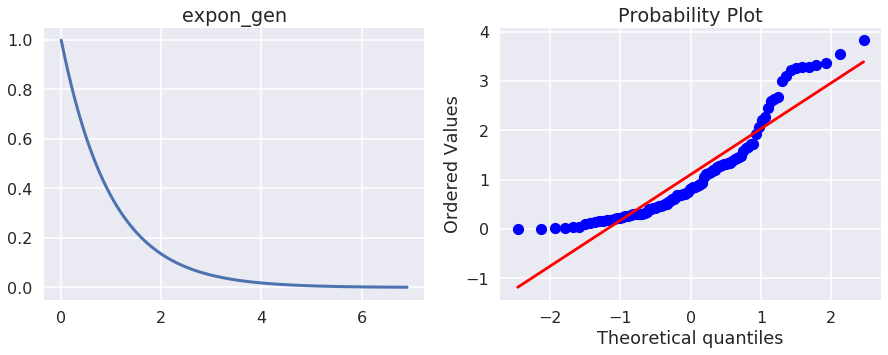

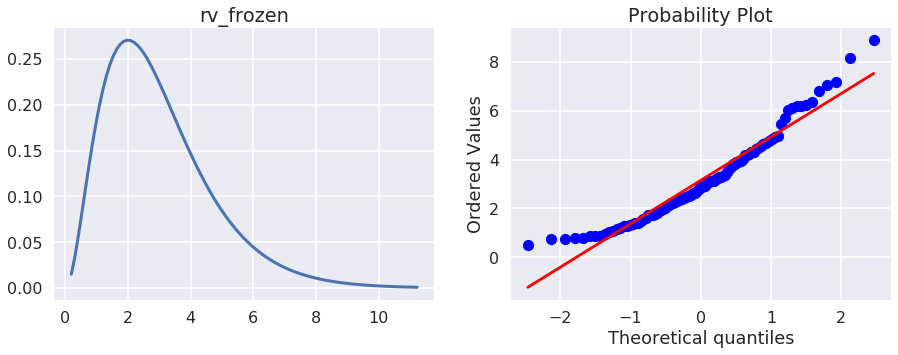

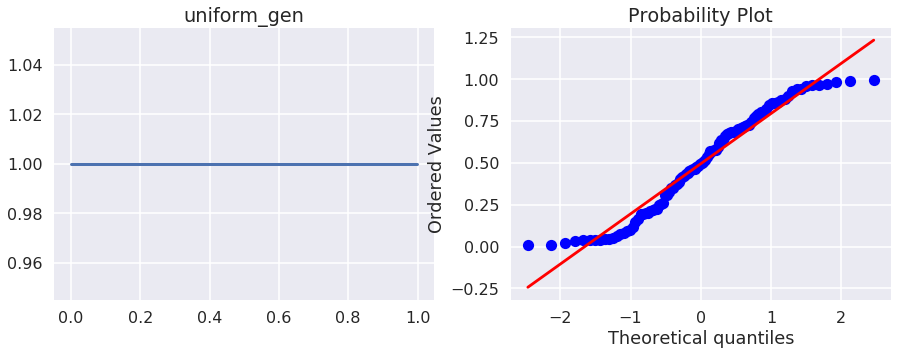

In [20]:
for distr in [sps.norm, sps.norm(2, 100), sps.laplace, sps.cauchy, 
              sps.expon, sps.gamma(a=3), sps.uniform]:
    sample = distr.rvs(size=100)

    plt.figure(figsize=(15, 5))

    ax = plt.subplot(1, 2, 1)
    grid = np.linspace(distr.ppf(0.001), distr.ppf(0.999), 100)
    plt.plot(grid, distr.pdf(grid), lw=3)
    plt.title(str(distr).split(' ')[0].split('.')[-1])

    ax = plt.subplot(1, 2, 2)
    sps.probplot(sample, plot=ax)

    plt.show()

### Критерий Шапиро-Уилка

$H_0:$ Выборка из нормального распределения

$H_1: H_0$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro">`shapiro`</a>`(x): W, p-value`

In [21]:
sps.shapiro(sps.norm.rvs(size=100))

(0.9906405806541443, 0.7163025736808777)

In [22]:
sps.shapiro(sps.norm(20, 100).rvs(size=100))

(0.9892095327377319, 0.6011274456977844)

In [23]:
sps.shapiro(sps.laplace.rvs(size=100))

(0.9798112511634827, 0.12850984930992126)

In [24]:
sps.shapiro(sps.cauchy.rvs(size=100))

(0.5020333528518677, 8.309747907611349e-17)

### Критерий Жарка-Бера

$H_0:$ Выборка из нормального распределения

$H_1: H_0$ не верна.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html#scipy.stats.jarque_bera">`jarque_bera`</a>`(x): jb_value, p-value`

In [25]:
sps.jarque_bera(sps.norm.rvs(size=100))

(0.5879976746802396, 0.7452773579468688)

In [26]:
sps.jarque_bera(sps.norm(20, 100).rvs(size=100))

(1.503106513439623, 0.47163341574113893)

In [27]:
sps.jarque_bera(sps.laplace.rvs(size=100))

(35.1555233819867, 2.3231384482791384e-08)

In [28]:
sps.jarque_bera(sps.cauchy.rvs(size=100))

(5895.396376690182, 0.0)

## Пример: эксперимент Майкельсона

Данные классического эксперимента Майкельсона по измерению скорости света с помощью вращающегося зеркала, 100 наблюдений:

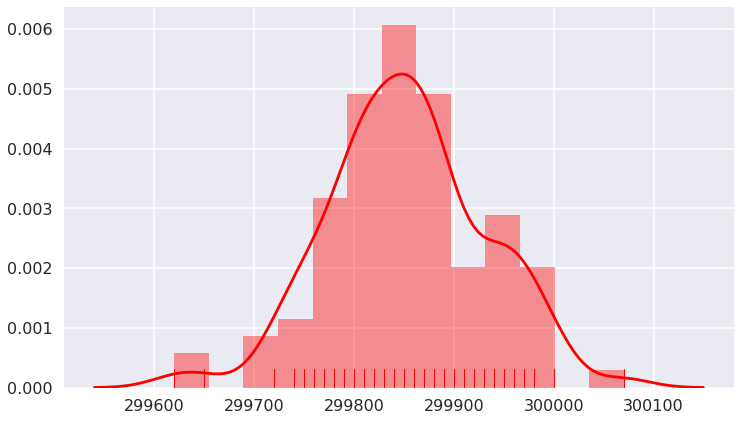

In [34]:
speed = np.loadtxt('speed.txt')

plt.figure(figsize=(12, 7))
sns.distplot(speed, rug=True, color='red');

Построим Q-Q plot

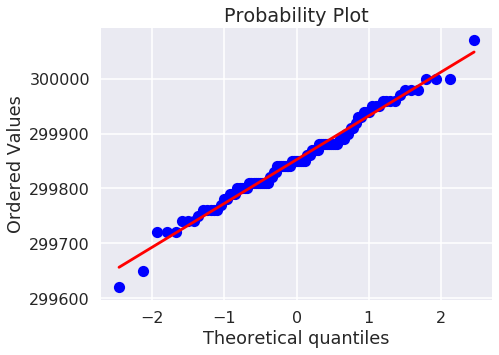

In [35]:
plt.figure(figsize=(7, 5))
sps.probplot(speed, plot=plt.subplot(111));

Применим критерии согласия и соберем их p-value в массив

In [38]:
pvalues = [sps.kstest(speed, sps.norm(*sps.norm.fit(speed)).cdf)[1],
           sps.shapiro(speed)[1],
           sps.jarque_bera(speed)[1]]

pvalues

[0.4813808419520871, 0.5140784382820129, 0.8628948044152577]

Применим множественную проверку гипотез. Ни один критерий нормальности гипотезу не отвергает, поэтому итог: нормальность не отвергается. Если хотя бы один критерий отвергал, но гипотезу стоило бы отвергнуть.

In [39]:
multipletests(pvalues)

(array([False, False, False]),
 array([0.86050917, 0.86050917, 0.8628948 ]),
 0.016952427508441503,
 0.016666666666666666)